<a href="https://colab.research.google.com/github/AllergictoCrustaceans/ML/blob/main/multilabel_classification_fetal_health.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classify Fetal Health

Prompt: Given patients' cardiotocograms (CTGs) data, predict the patient's fetal health (normal, suspect, pathological).

Where is data from: https://www.kaggle.com/andrewmvd/fetal-health-classification

ML Type: Compare Random Forest Classifer V. keras.layers model, Added Weights

In [1]:
import tensorflow as tf
import tensorflow.keras as keras

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from numpy import mean, std

!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 4.6MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=2b5f62c80f561d8447506f66ea8a4c302925e534ae0af7d79d3f3e756ec9ba4c
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.10
    Uninstalling kaggle-1.5.10:
      Successfully uninstalled kaggle-1.5.10


### 1.) Connect to Kaggle API

In [2]:
from google.colab import files
files.upload() # Browse for the kaggle.json file that you downloaded

# Make directory named kaggle, copy kaggle.json file there, and change the permissions of the file.
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

# You can check if everything's okay by running this command.
! kaggle datasets list

Saving kaggle.json to kaggle.json
ref                                                         title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              216KB  2021-03-22 08:03:57            756         90  1.0              
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-02-17 16:10:44            640         78  1.0              
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   1GB  2021-02-18 10:08:27            601         79  1.0              
imsparsh/musicnet-dataset                               

### 2.) Load Kaggle Dataset

In [3]:
!kaggle datasets download -d andrewmvd/fetal-health-classification --unzip

  0% 0.00/45.8k [00:00<?, ?B/s]
100% 45.8k/45.8k [00:00<00:00, 33.3MB/s]


In [4]:
ds_raw = pd.read_csv('/content/fetal_health.csv')

### 3.) Inspect

In [5]:
# Check dtype, nulls.
ds_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   float64
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   float64
 8   mean_value_of_short_term_variability  

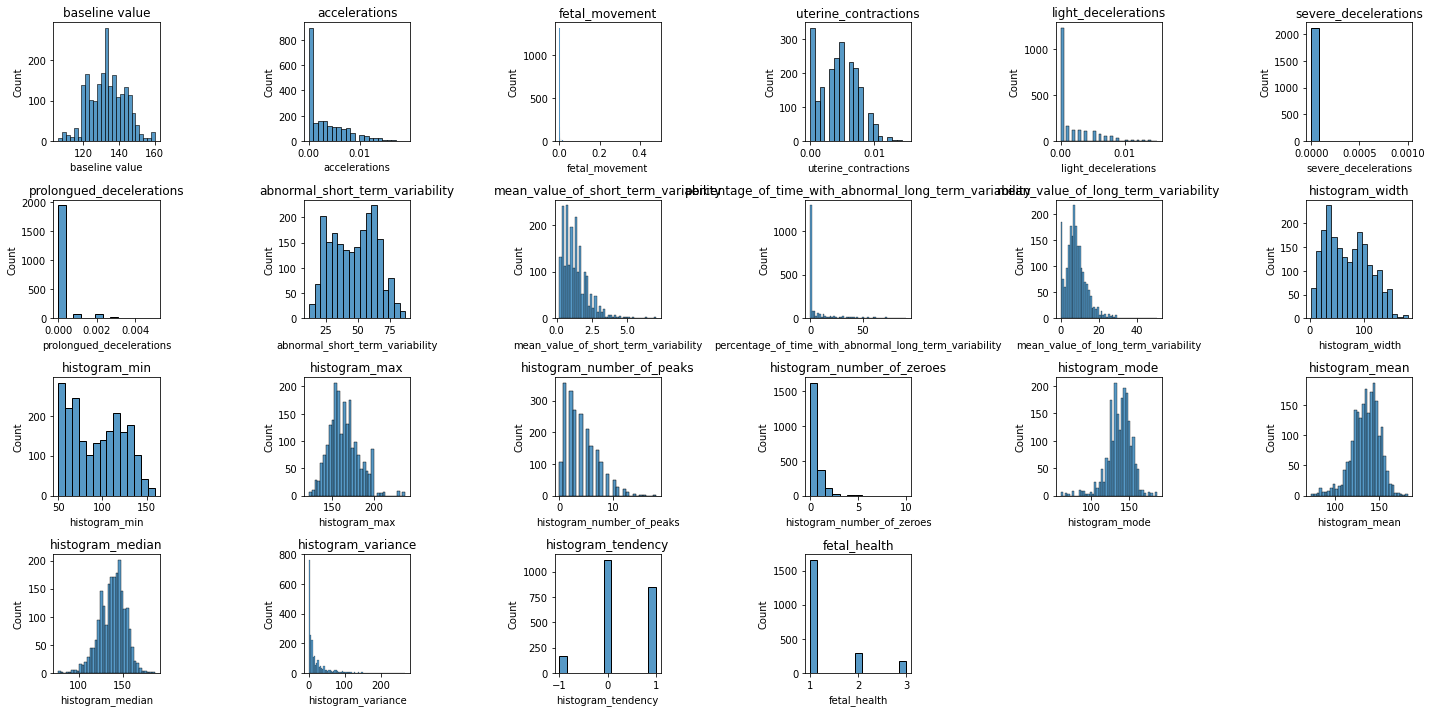

In [6]:
# Check distribution of features

plt.figure(figsize=(20, 10))

for i, column in enumerate(ds_raw.columns):
    plt.subplot(4, 6, i+1)
    sns.histplot(data=ds_raw[column])
    plt.title(column)

plt.tight_layout()
plt.show()

Based off of the graphs, it seems like majority of the features are normally distirbuted. The only few feautres that are skewed 'accelerations', 'light_accelerations', 'severe decerlations', 'prolonged_decelerations', and 'mean_value_of_short_term_variability'.

As for the histogram features, I wonder what they are specifically histograms of.

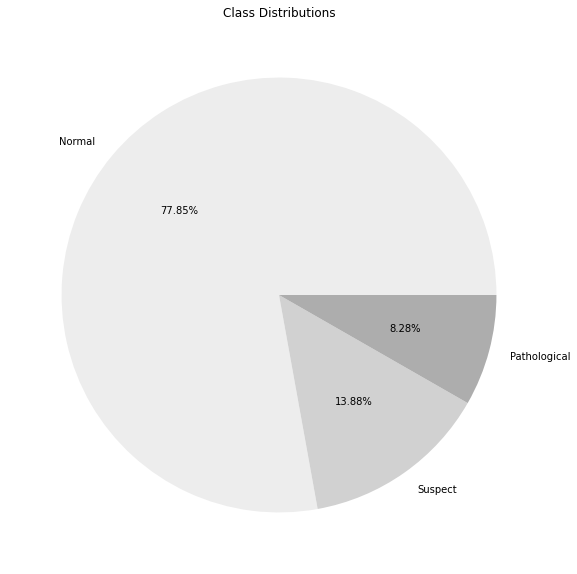

In [7]:
# Check data imbalance
plt.figure(figsize=(10, 10))

plt.pie(ds_raw['fetal_health'].value_counts(),
       autopct='%0.2f%%',
       labels=['Normal', 'Suspect', 'Pathological'],
       colors=sns.color_palette('Greys'))

plt.title('Class Distributions')
plt.show()

### 4.) Clean



In [8]:
ds = ds_raw.copy()

# rename column 'baseline value' to be 'baseline_value'
ds.rename(columns={"baseline value": "baseline_value"}, inplace=True)
print(ds.columns)

Index(['baseline_value', 'accelerations', 'fetal_movement',
       'uterine_contractions', 'light_decelerations', 'severe_decelerations',
       'prolongued_decelerations', 'abnormal_short_term_variability',
       'mean_value_of_short_term_variability',
       'percentage_of_time_with_abnormal_long_term_variability',
       'mean_value_of_long_term_variability', 'histogram_width',
       'histogram_min', 'histogram_max', 'histogram_number_of_peaks',
       'histogram_number_of_zeroes', 'histogram_mode', 'histogram_mean',
       'histogram_median', 'histogram_variance', 'histogram_tendency',
       'fetal_health'],
      dtype='object')


### 5.) Split

In [9]:
train_df, test_df = train_test_split(ds, test_size=0.2, stratify=ds['fetal_health'])
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['fetal_health'])

y_train = train_df['fetal_health']
y_val = test_df['fetal_health']
y_test = val_df['fetal_health']

x_train = train_df.drop('fetal_health', 1)
x_test = train_df.drop('fetal_health', 1)
x_val = val_df.drop('fetal_health', 1)

### 5.) Preprocess

#### Normalize

In [10]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_val = scaler.transform(x_val)

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

In [11]:
# Check dataset shapes
x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

((1360, 21), (1360,), (1360, 21), (340,), (340, 21), (426,))

#### Feature Selection

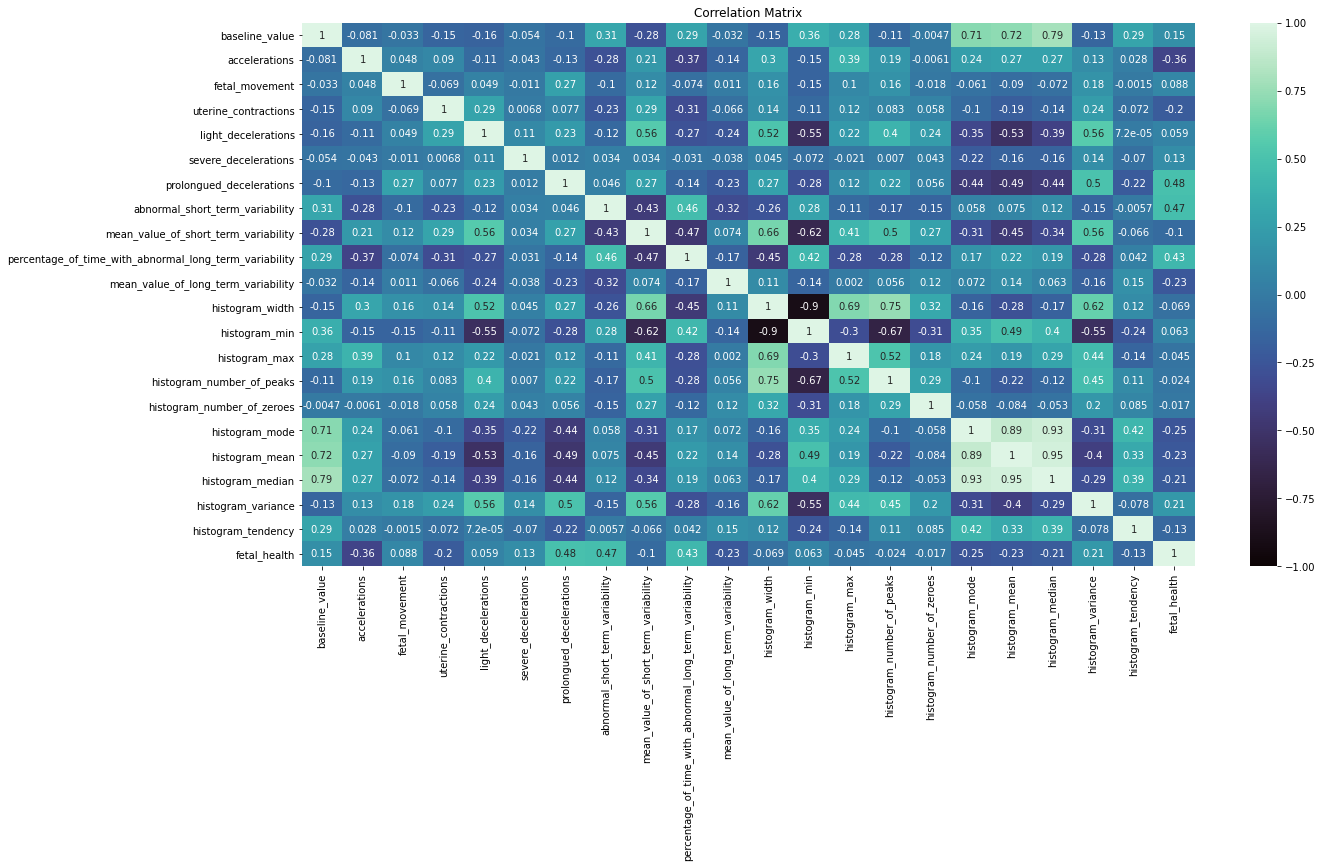

fetal_health    1.0
Name: fetal_health, dtype: float64

In [12]:
# Pearson correlation
corr = ds.corr()

plt.figure(figsize=(20, 10))
sns.heatmap(corr, annot=True, vmin=-1.0, cmap='mako')
plt.title('Correlation Matrix')
plt.show()


cor_target = abs(corr['fetal_health'])
rel_features = cor_target[cor_target > 0.5]
rel_features
# There appears to be no high correlation (x > 0.5) between any of the features. 

In [13]:
# Wrapper Method: backward elimination
import statsmodels.api as sm
X_1 = sm.add_constant(x_train)
model = sm.OLS(y_train, X_1).fit()
model.pvalues
# but what are the values associated to?

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


array([8.61996554e-137, 1.12910666e-010, 7.20508330e-001, 9.71515023e-001,
       2.14430350e-006, 5.12802852e-001, 1.71728142e-001, 1.83083378e-031,
       3.84312079e-024, 6.92355649e-001, 1.17805224e-041, 6.72940035e-003,
       8.40307159e-002, 2.53470353e-004, 4.79170036e-004, 6.06802707e-001,
       2.09299979e-001, 2.17076954e-001, 2.11424492e-001, 1.43403628e-003,
       1.93469679e-007, 6.04644088e-002])

In [14]:
# Wrapper Method: Recursive Feature Elimination (RFE)
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, Ridge, Lasso
from sklearn.feature_selection import RFE

X  = ds.drop('fetal_health', 1)
y = ds['fetal_health']

n_list = np.arange(1, 13)
high_score = 0
n = 0
score_list = []

# find optimal number of features
for i in range(len(n_list)):
    x_train, x_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)
    rfe_model = LinearRegression()
    rfe = RFE(rfe_model, n_list[i])
    x_train_rfe = rfe.fit_transform(x_train, y_train)
    x_test_rfe = rfe.transform(x_test)
    rfe_model.fit(x_train_rfe, y_train)

    score = rfe_model.score(x_test_rfe, y_test)
    score_list.append(score)
    
    if (score > high_score):
        high_score = score
        n = n_list[i]

print('optimum number of features: %d' %n)
print('Score with %d features: %f' % (n, high_score))



# find what those optimal features are
cols = list(X.columns)
rfe_model = LinearRegression()
rfe = RFE(rfe_model, 12)
x_rfe = rfe.fit_transform(X, y)
rfe_model.fit(x_rfe, y)

temp = pd.Series(rfe.support_, index=cols)
selected_features_rfe = temp[temp==True].index

print(selected_features_rfe)

optimum number of features: 12
Score with 12 features: 0.446868
Index(['baseline_value', 'accelerations', 'fetal_movement',
       'uterine_contractions', 'light_decelerations', 'severe_decelerations',
       'prolongued_decelerations', 'abnormal_short_term_variability',
       'percentage_of_time_with_abnormal_long_term_variability',
       'histogram_number_of_zeroes', 'histogram_median', 'histogram_tendency'],
      dtype='object')


#### Embedded Method


Best alpha using LassoCV: 0.040352
Best score using LassoCV: 0.526640
Lasso picked 10 variables and eliminated the other 11 variables


Text(0.5, 1.0, 'Feature importance using LassoCV')

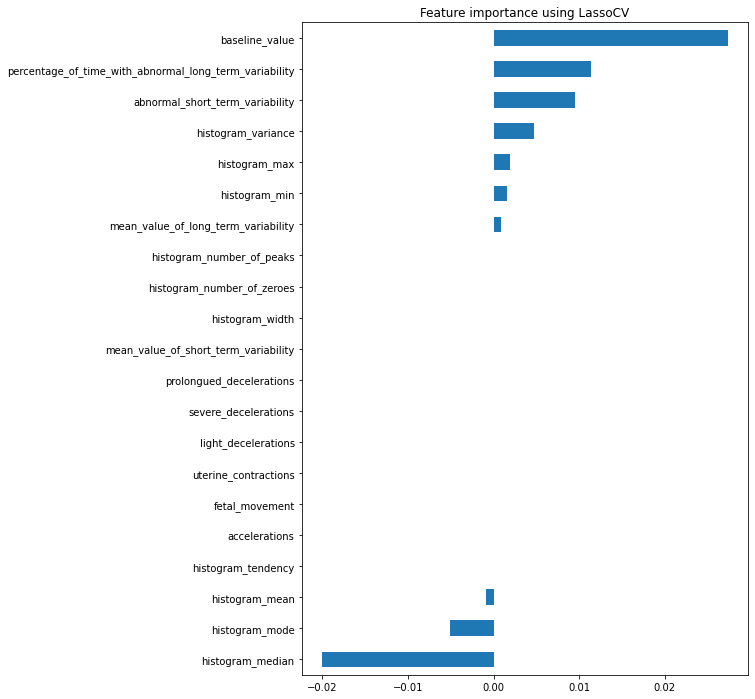

In [15]:
# Lasso
lasso_reg = LassoCV()
lasso_reg.fit(X, y)
print('Best alpha using LassoCV: %f' % lasso_reg.alpha_)
print('Best score using LassoCV: %f' % lasso_reg.score(X, y))

coef = pd.Series(lasso_reg.coef_, index=X.columns)

print('Lasso picked ' + str(sum(coef != 0)) + ' variables and eliminated the other ' + str(sum(coef == 0)) + ' variables')

imp_coef = coef.sort_values()

import matplotlib

matplotlib.rcParams['figure.figsize'] = (8, 12)
imp_coef.plot(kind = 'barh')
plt.title('Feature importance using LassoCV')


You used the full ds instead of the splitted datasets. You'll have to transform the split datasets with the new filtered features.

### 6.) Build, Train, Evaluate

#### Random Forest Classifier without feature selection 

Balanced weights

In [16]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

def evaluate_model(x, y, model):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    scores = cross_val_score(model, x, y, scoring='accuracy', cv = cv, n_jobs=1)
    return scores

model = RandomForestClassifier(n_estimators=100, class_weight='balanced')
scores = evaluate_model(x_train, y_train, model)

model.fit(x_train, y_train)

# predict
model.predict_proba(x_test)
y_pred = model.predict(x_test)
acc = accuracy_score(y_test, y_pred) * 100
print(" Mean accuracy given test data: ", acc)

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix: \n', cm)

# classification report
class_report = classification_report(y_test, y_pred)
print('Classification report: \n', class_report)

print('Mean accuracy with cross_val: %0.3f (%0.3f)' % (mean(scores), std(scores)))

 Mean accuracy given test data: 
 94.20062695924764
Confusion Matrix: 
 [[487   7   0]
 [ 23  61   2]
 [  1   4  53]]
Classification report: 
               precision    recall  f1-score   support

         1.0       0.95      0.99      0.97       494
         2.0       0.85      0.71      0.77        86
         3.0       0.96      0.91      0.94        58

    accuracy                           0.94       638
   macro avg       0.92      0.87      0.89       638
weighted avg       0.94      0.94      0.94       638

Mean accuracy with cross_val: 0.936 (0.009)


Customized Weights

In [19]:
count = ds['fetal_health'].value_counts()
total = count.sum()
normal = count[1]
suspect = count[2]
patho = count[3]


weight_for_1 = (1 / normal) * (total) / 3.0
weight_for_2 = (1 / suspect) * (total) / 3.0
weight_for_3 = (1 / patho) * (total) / 3.0

class_weight = {
    1: weight_for_1,
    2: weight_for_2,
    3: weight_for_3
}

print('weight for class 1: {:0.2f}'.format(weight_for_1))
print('weight for class 2: {:0.2f}'.format(weight_for_2))
print('weight for class 3: {:0.2f}'.format(weight_for_3))

weight for class 1: 0.43
weight for class 2: 2.40
weight for class 3: 4.03


In [20]:
model_custom = RandomForestClassifier(n_estimators=100, class_weight=class_weight)
scores_custom = evaluate_model(x_train, y_train, model_custom)

# fit
model_custom.fit(x_train, y_train)

# predict
model_custom.predict_proba(x_test)
y_pred = model_custom.predict(x_test)
acc = accuracy_score(y_test, y_pred) * 100
print(" Mean accuracy given test data: ", acc)

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix: \n', cm)

# classification report
class_report = classification_report(y_test, y_pred)
print('Classification report: \n', class_report)

print('Mean accuracy with cross_val: %0.3f (%0.3f)' % (mean(scores_custom), std(scores_custom)))

 Mean accuracy given test data:  93.73040752351098
Confusion Matrix: 
 [[485   8   1]
 [ 24  60   2]
 [  1   4  53]]
Classification report: 
               precision    recall  f1-score   support

         1.0       0.95      0.98      0.97       494
         2.0       0.83      0.70      0.76        86
         3.0       0.95      0.91      0.93        58

    accuracy                           0.94       638
   macro avg       0.91      0.86      0.89       638
weighted avg       0.93      0.94      0.93       638

Mean accuracy with cross_val: 0.935 (0.007)


The goal of training model with different weight implementaitons is to find model performance/metric differences. 

When trained with Random Forest Classifier, the model seems to have performed about the same with balanced (94%) /customized weights (93%).

#### Random Forest Classifier with Feature Selection

Balanced weights

In [21]:
# drop the unimpactful features: 
x_train_filtered = x_train.drop(['histogram_number_of_peaks',
                                 'histogram_number_of_zeroes',
                                 'mean_value_of_short_term_variability',
                                 'histogram_width',
                                 'histogram_tendency',
                                 'prolongued_decelerations',
                                 'severe_decelerations',
                                 'light_decelerations',
                                 'uterine_contractions',
                                 'fetal_movement',
                                 'accelerations'], axis=1)
x_test_filtered = x_test.drop(['histogram_number_of_peaks',
                                 'histogram_number_of_zeroes',
                                 'mean_value_of_short_term_variability',
                                 'histogram_width',
                                 'histogram_tendency',
                                 'prolongued_decelerations',
                                 'severe_decelerations',
                                 'light_decelerations',
                                 'uterine_contractions',
                                 'fetal_movement',
                                 'accelerations'], axis=1)

print(x_train_filtered.shape)
print(x_test_filtered.shape)

(1488, 10)
(638, 10)


In [22]:
model_filtered = RandomForestClassifier(n_estimators=100, class_weight='balanced')
scores_filtered = evaluate_model(x_train_filtered, y_train, model_filtered)

model_filtered.fit(x_train_filtered, y_train)

# predict
model_filtered.predict_proba(x_test_filtered)
y_pred_filtered = model_filtered.predict(x_test_filtered)
acc_filtered = accuracy_score(y_test, y_pred_filtered) * 100
print(" Mean accuracy given test data: ", acc_filtered)

# confusion matrix
cm_filtered = confusion_matrix(y_test, y_pred_filtered)
print('Confusion Matrix: \n', cm)

# classification report
class_report_filtered = classification_report(y_test, y_pred_filtered)
print('Classification report: \n', class_report_filtered)

print('Mean accuracy with cross_val: %0.3f (%0.3f)' % (mean(scores_filtered), std(scores_filtered)))

 Mean accuracy given test data: 
 93.73040752351098
Confusion Matrix: 
 [[485   8   1]
 [ 24  60   2]
 [  1   4  53]]
Classification report: 
               precision    recall  f1-score   support

         1.0       0.95      0.98      0.97       494
         2.0       0.84      0.69      0.76        86
         3.0       0.96      0.91      0.94        58

    accuracy                           0.94       638
   macro avg       0.92      0.86      0.89       638
weighted avg       0.93      0.94      0.93       638

Mean accuracy with cross_val: 0.931 (0.012)


Customized weights

In [23]:
model_filtered_custom = RandomForestClassifier(n_estimators=100, class_weight=class_weight)
scores_filtered_custom = evaluate_model(x_train_filtered, y_train, model_filtered_custom)

# fit
model_filtered_custom.fit(x_train_filtered, y_train)

# predict
model_filtered_custom.predict_proba(x_test_filtered)
y_pred_filtered_custom = model_filtered_custom.predict(x_test_filtered)
acc_filtered_custom = accuracy_score(y_test, y_pred_filtered_custom) * 100
print(" Mean accuracy given test data: ", acc_filtered_custom)

# confusion matrix
cm_filtered_custom = confusion_matrix(y_test, y_pred_filtered_custom)
print('Confusion Matrix: \n', cm_filtered_custom)

# classification report
class_report_filtered_custom = classification_report(y_test, y_pred_filtered_custom)
print('Classification report: \n', class_report_filtered_custom)

print('Mean accuracy with cross_val: %0.3f (%0.3f)' % (mean(scores_filtered_custom), std(scores_filtered_custom)))

 Mean accuracy given test data:  93.8871473354232
Confusion Matrix: 
 [[485   7   2]
 [ 25  59   2]
 [  0   3  55]]
Classification report: 
               precision    recall  f1-score   support

         1.0       0.95      0.98      0.97       494
         2.0       0.86      0.69      0.76        86
         3.0       0.93      0.95      0.94        58

    accuracy                           0.94       638
   macro avg       0.91      0.87      0.89       638
weighted avg       0.94      0.94      0.94       638

Mean accuracy with cross_val: 0.930 (0.011)


### 5.) Thoughts
- What other multilabel classification algorithms can you try? 

- Doesn't seem like feature selection helped improve the accuracy much after dropping "unimpactful" features. Why is that?